In [140]:
import os
from dotenv import load_dotenv

try:
    load_dotenv()
    GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
    # print(GOOGLE_API_KEY)

except Exception as e:
    print(f"Error loading environment variables: {e}")

In [141]:
from google.adk.agents import Agent, SequentialAgent, ParallelAgent, LoopAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import InMemoryRunner
from google.adk.tools import AgentTool, FunctionTool, google_search
from google.genai import types

import asyncio

print("✅ ADK components imported successfully.")

✅ ADK components imported successfully.


In [142]:
retry_config = types.HttpRetryOptions(
    attempts=5, exp_base=7, initial_delay=1, http_status_codes=[429, 500, 503, 504]
)

In [143]:
# Research Agent: Its job is to use the google_search tool and present findings.
research_agent = Agent(
    name="ResearchAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""You are a specialized research agent. Your only job is to use the
    google_search tool to find 2-3 pieces of relevant information on the given topic and present the findings with citations.""",
    tools=[google_search],
    output_key="research_findings",  # The result of this agent will be stored in the session state with this key.
)

print("research_agent created.")

research_agent created.


Why Multi-Agent Systems? + Your First Multi-Agent
The Problem: The "Do-It-All" Agent

Single agents can do a lot. But what happens when the task gets complex? A single "monolithic" agent that tries to do research, writing, editing, and fact-checking all at once becomes a problem. Its instruction prompt gets long and confusing. It's hard to debug (which part failed?), difficult to maintain, and often produces unreliable results.

The Solution: A Team of Specialists

Instead of one "do-it-all" agent, we can build a multi-agent system. This is a team of simple, specialized agents that collaborate, just like a real-world team. Each agent has one clear job (e.g., one agent only does research, another only writes). This makes them easier to build, easier to test, and much more powerful and reliable when working together.

In [144]:
# Summarizer Agent: Its job is to summarize the text it receives.
summarizer_agent = Agent(
    name="SummarizerAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    # The instruction is modified to request a bulleted list for a clear output format.
    instruction="""Read the provided research findings: {research_findings}
Create a concise summary as a bulleted list with 3-5 key points.""",
    output_key="final_summary",
)

print("summarizer_agent created.")

summarizer_agent created.


In [145]:
# Root Coordinator: Orchestrates the workflow by calling the sub-agents as tools.
root_agent = Agent(
    name="ResearchCoordinator",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    # This instruction tells the root agent HOW to use its tools (which are the other agents).
    instruction="""You are a research coordinator. Your goal is to answer the user's query by orchestrating a workflow.
1. First, you MUST call the `ResearchAgent` tool to find relevant information on the topic provided by the user.
2. Next, after receiving the research findings, you MUST call the `SummarizerAgent` tool to create a concise summary.
3. Finally, present the final summary clearly to the user as your response.""",
    # We wrap the sub-agents in `AgentTool` to make them callable tools for the root agent.
    tools=[AgentTool(research_agent), AgentTool(summarizer_agent)],
)

print("root_agent created.")

root_agent created.


In [146]:
runner = InMemoryRunner(agent=root_agent)
response = await runner.run_debug(
    "What are the latest advancements in quantum computing and what do they mean for AI? explain in 3 points in laymanterms"
)


 ### Created new session: debug_session_id

User > What are the latest advancements in quantum computing and what do they mean for AI? explain in 3 points in laymanterms


ResearchCoordinator > Here's a summary of the research findings:

*   **Super-fast calculations:** Quantum computers can explore many possibilities at once, making them much faster at solving complex AI problems with huge amounts of data.
*   **Smarter AI and new tricks:** They enable new, more efficient AI programs that can learn faster and solve problems like finding new medicines or understanding language better.
*   **Greener AI:** Quantum computing could make training AI models require less energy and computing power, making AI development more sustainable.


Sequential Workflows - The Assembly Line
The Problem: Unpredictable Order

The previous multi-agent system worked, but it relied on a detailed instruction prompt to force the LLM to run steps in order. This can be unreliable. A complex LLM might decide to skip a step, run them in the wrong order, or get "stuck," making the process unpredictable.

The Solution: A Fixed Pipeline

When you need tasks to happen in a guaranteed, specific order, you can use a SequentialAgent. This agent acts like an assembly line, running each sub-agent in the exact order you list them. The output of one agent automatically becomes the input for the next, creating a predictable and reliable workflow.

Use Sequential when: Order matters, you need a linear pipeline, or each step builds on the previous one.

Architecture: Blog Post Creation Pipeline

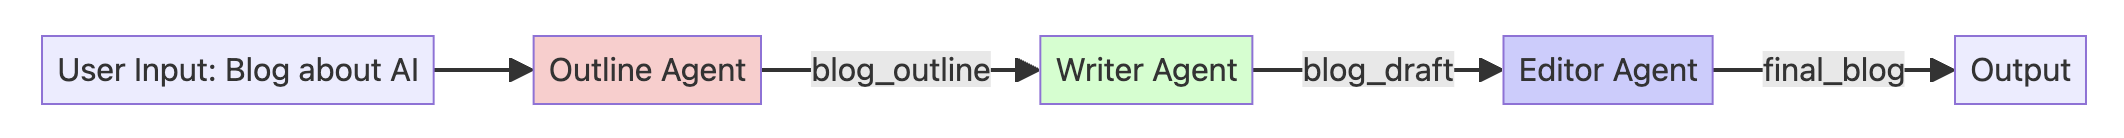

Example: Blog Post Creation with Sequential Agents
Let's build a system with three specialized agents:

Outline Agent - Creates a blog outline for a given topic
Writer Agent - Writes a blog post
Editor Agent - Edits a blog post draft for clarity and structure

In [147]:
# Outline Agent: Creates the initial blog post outline.
outline_agent = Agent(
    name="OutlineAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""Create a blog outline for the given topic with:
    1. A catchy headline
    2. An introduction hook
    3. 3-5 main sections with 2-3 bullet points for each
    4. A concluding thought""",
    output_key="blog_outline",  # The result of this agent will be stored in the session state with this key.
)

print("outline_agent created.")

outline_agent created.


In [148]:
# Writer Agent: Writes the full blog post based on the outline from the previous agent.
writer_agent = Agent(
    name="WriterAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    # The `{blog_outline}` placeholder automatically injects the state value from the previous agent's output.
    instruction="""Following this outline strictly: {blog_outline}
    Write a brief, 200 to 300-word blog post with an engaging and informative tone.""",
    output_key="blog_draft",  # The result of this agent will be stored with this key.
)

print("writer_agent created.")

writer_agent created.


In [149]:
# Editor Agent: Edits and polishes the draft from the writer agent.
editor_agent = Agent(
    name="EditorAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    # This agent receives the `{blog_draft}` from the writer agent's output.
    instruction="""Edit this draft: {blog_draft}
    Your task is to polish the text by fixing any grammatical errors, improving the flow and sentence structure, and enhancing overall clarity.""",
    output_key="final_blog",  # This is the final output of the entire pipeline.
)

print("editor_agent created.")

editor_agent created.


In [150]:
root_agent = SequentialAgent(
    name="BlogPipeline",
    sub_agents=[outline_agent, writer_agent, editor_agent],
)

print("Sequential Agent created.")

Sequential Agent created.


In [151]:
runner = InMemoryRunner(agent=root_agent)
response = await runner.run_debug("Write a blog post about the benefits of multi-agent systems for software developers")


 ### Created new session: debug_session_id

User > Write a blog post about the benefits of multi-agent systems for software developers
OutlineAgent > Sure, I can help with that! Here's a blog outline about the benefits of multi-agent systems for software developers:

## Unleash Your Code's Potential: Why Multi-Agent Systems Are Your Next Big Tool

**Introduction Hook:** Tired of monolithic codebases that creak and groan under the weight of complexity? Imagine a software architecture where independent, intelligent "agents" collaborate to solve problems, adapt to change, and scale effortlessly. This isn't science fiction – it's the power of multi-agent systems, and it's about to revolutionize how you build software.

---

### **Main Section 1: Enhanced Modularity and Maintainability**

*   **Decomposition into Independent Units:** Break down complex problems into smaller, manageable tasks, each handled by a specialized agent. This makes code easier to understand, debug, and modify.
*   

Parallel Workflows - Independent Researchers

The Problem: The Bottleneck

The previous sequential agent is great, but it's an assembly line. Each step must wait for the previous one to finish. What if you have several tasks that are not dependent on each other? For example, researching three different topics. Running them in sequence would be slow and inefficient, creating a bottleneck where each task waits unnecessarily.

The Solution: Concurrent Execution

When you have independent tasks, you can run them all at the same time using a ParallelAgent. This agent executes all of its sub-agents concurrently, dramatically speeding up the workflow. Once all parallel tasks are complete, you can then pass their combined results to a final 'aggregator' step.

Use Parallel when: Tasks are independent, speed matters, and you can execute concurrently.

In [152]:
tech_researcher = Agent(
    name="TechResearcher",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    instruction="""Research the latest AI/ML trends. Include 3 key developments,
the main companies involved, and the potential impact. Keep the report very concise (100 words).""",
    tools=[google_search],
    output_key="tech_research",
)
print("tech_research created")

tech_research created


In [153]:
# Health Researcher: Focuses on medical breakthroughs.
health_researcher = Agent(
    name="HealthResearcher",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""Research recent medical breakthroughs. Include 3 significant advances,
their practical applications, and estimated timelines. Keep the report concise (100 words).""",
    tools=[google_search],
    output_key="health_research",  # The result will be stored with this key.
)

print("health_researcher created.")

health_researcher created.


In [154]:
finance_researcher = Agent(
    name="FinanceResearcher",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""Research current fintech trends. Include 3 key trends,
their market implications, and the future outlook. Keep the report concise (100 words).""",
    tools=[google_search],
    output_key="finance_research"
)
print("finance_research created")

finance_research created


In [155]:
aggregator_agent = Agent(
    name="AggregatorAgent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    instruction="""Combine these three research findings into a single executive summary:

    **Technology Trends:**
    {tech_research}
    
    **Health Breakthroughs:**
    {health_research}
    
    **Finance Innovations:**
    {finance_research}
    
    Your summary should highlight common themes, surprising connections, and the most important key takeaways from all three reports. The final summary should be around 200 words.""",
    output_key="executive_summary",
)
print("aggregator_agent created")

aggregator_agent created


Then we bring the agents together under a parallel agent, which is itself nested inside of a sequential agent.

This design ensures that the research agents run first in parallel, then once all of their research is complete, the aggregator agent brings together all of the research findings into a single report:

In [156]:
# The ParallelAgent runs all its sub-agents simultaneously.
parallel_research_team = ParallelAgent(
    name="ParallelResearchTeam",
    sub_agents=[tech_researcher, health_researcher, finance_researcher],
)

# This SequentialAgent defines the high-level workflow: run the parallel team first, then run the aggregator.
root_agent = SequentialAgent(
    name="ResearchSystem",
    sub_agents=[parallel_research_team, aggregator_agent],
)

print("Parallel and Sequential Agents created.")

Parallel and Sequential Agents created.


In [157]:
runner = InMemoryRunner(agent=root_agent)
response = await runner.run_debug(
    "Run the daily executive briefing on Tech, Health, and Finance"
)


 ### Created new session: debug_session_id

User > Run the daily executive briefing on Tech, Health, and Finance
FinanceResearcher > **Key Fintech Trends: November 2025**

**1. AI Integration and Agentic Workflows:**
Artificial Intelligence is rapidly evolving beyond simple chatbots to "agentic AI." These systems can autonomously perform complex tasks and make decisions, revolutionizing financial operations. Market implications include enhanced fraud detection, personalized financial advice, and more efficient back-office processes. The future outlook points to AI becoming indispensable for data-driven financial strategies.

**2. Market Volatility and Strategic Consolidation:**
Global equity markets are experiencing increased volatility, with potential corrections predicted. In response, some regions, like India, are pursuing banking consolidation through mega-mergers to enhance efficiency and global competitiveness. This trend implies a future focused on resilient, data-backed financ

Loop Workflows - The Refinement Cycle

The Problem: One-Shot Quality
All the workflows we've seen so far run from start to finish. The SequentialAgent and ParallelAgent produce their final output and then stop. This 'one-shot' approach isn't good for tasks that require refinement and quality control. What if the first draft of our story is bad? We have no way to review it and ask for a rewrite.

The Solution: Iterative Refinement
When a task needs to be improved through cycles of feedback and revision, you can use a LoopAgent. A LoopAgent runs a set of sub-agents repeatedly until a specific condition is met or a maximum number of iterations is reached. This creates a refinement cycle, allowing the agent system to improve its own work over and over.

Use Loop when: Iterative improvement is needed, quality refinement matters, or you need repeated cycles.

Architecture: Story Writing & Critique Loop

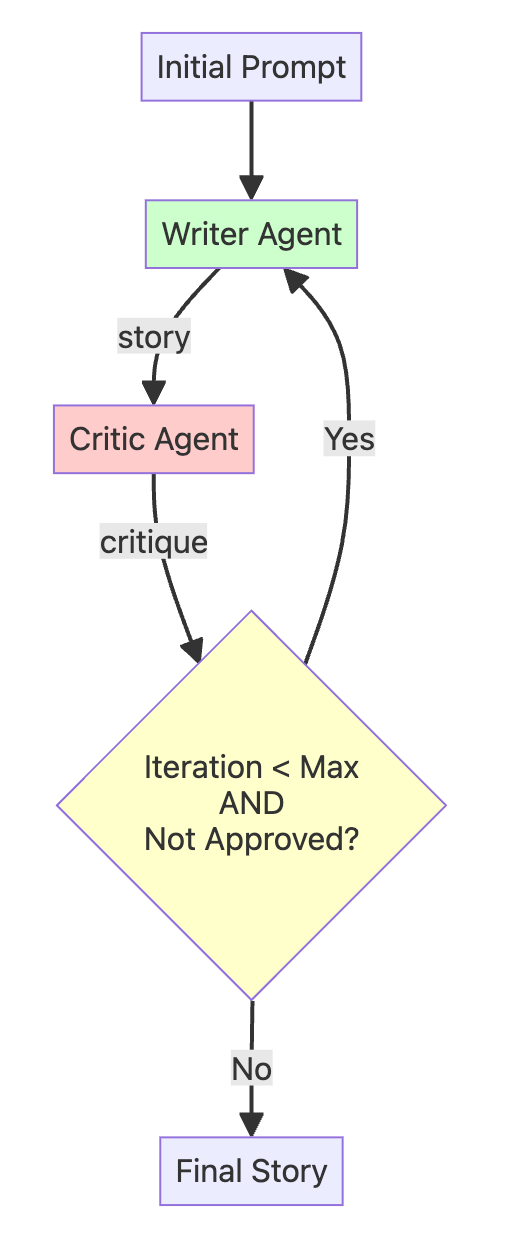

In [158]:
initial_writer_agent = Agent(
    name="InitialWriterAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""Based on the user's prompt, write the first draft of a short story (around 100-150 words).
    Output only the story text, with no introduction or explanation.""",
    output_key="current_story",
)
print("initial_writer_agent created.")

initial_writer_agent created.


In [159]:
critic_agent = Agent(
    name="CriticAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""You are a constructive story critic. Review the story provided below.
    Story: {current_story}
    
    Evaluate the story's plot, characters, and pacing.
    - If the story is well-written and complete, you MUST respond with the exact phrase: "APPROVED"
    - Otherwise, provide 2-3 specific, actionable suggestions for improvement.""",
    output_key="critique",
)
print("critic_agent created.")

critic_agent created.


In [160]:
def exit_loop():
    """Call this function ONLY when the critique is 'APPROVED', indicating the story is finished and no more changes are needed."""
    return {"status":"approved","message":"Story approved. Exiting refinement loop."}
print("exit_loop function created.")

exit_loop function created.


In [162]:
refiner_agent = Agent(
    name="RefinerAgent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    instruction="""You are a story refiner. You have a story draft and critique.
    
    Story Draft: {current_story}
    Critique: {critique}
    
    Your task is to analyze the critique.
    - IF the critique is EXACTLY "APPROVED", you MUST call the `exit_loop` function and nothing else.
    - OTHERWISE, rewrite the story draft to fully incorporate the feedback from the critique.""",
    output_key="current_key",
    tools=[FunctionTool(exit_loop)],
)
print("refiner_agent created.")

refiner_agent created.


In [163]:
story_refinement_loop = LoopAgent(
    name="StoryRefinementLoop",
    sub_agents=[critic_agent,refiner_agent],
    max_iterations=2    
)
root_agent=SequentialAgent(
    name="StoryPipeline",
    sub_agents=[initial_writer_agent,story_refinement_loop]
)
print("Loop and Sequential Agents created.")

Loop and Sequential Agents created.


In [165]:
runner=InMemoryRunner(agent=root_agent)
response= await runner.run_debug(
    "write a python code to add n number of sum"
)


 ### Created new session: debug_session_id

User > write a python code to add n number of sum
InitialWriterAgent > ```python
def add_n_numbers(numbers):
  """
  This function takes a list of numbers and returns their sum.
  """
  total = 0
  for number in numbers:
    total += number
  return total

# Example usage:
my_list = [1, 2, 3, 4, 5]
result = add_n_numbers(my_list)
print(f"The sum of the numbers is: {result}")

# Another example with user input
# num_count = int(input("How many numbers do you want to add? "))
# user_numbers = []
# for i in range(num_count):
#   user_numbers.append(float(input(f"Enter number {i+1}: ")))
#
# result_user = add_n_numbers(user_numbers)
# print(f"The sum of your numbers is: {result_user}")
```
CriticAgent > This submission is a Python code snippet, not a story. Therefore, concepts like plot, characters, and pacing are not applicable. The code itself is functional and achieves the stated goal of adding numbers from a list.

Here are a couple of sugge

CriticAgent > APPROVED


Choosing the Right Pattern
Decision Tree: Which Workflow Pattern?

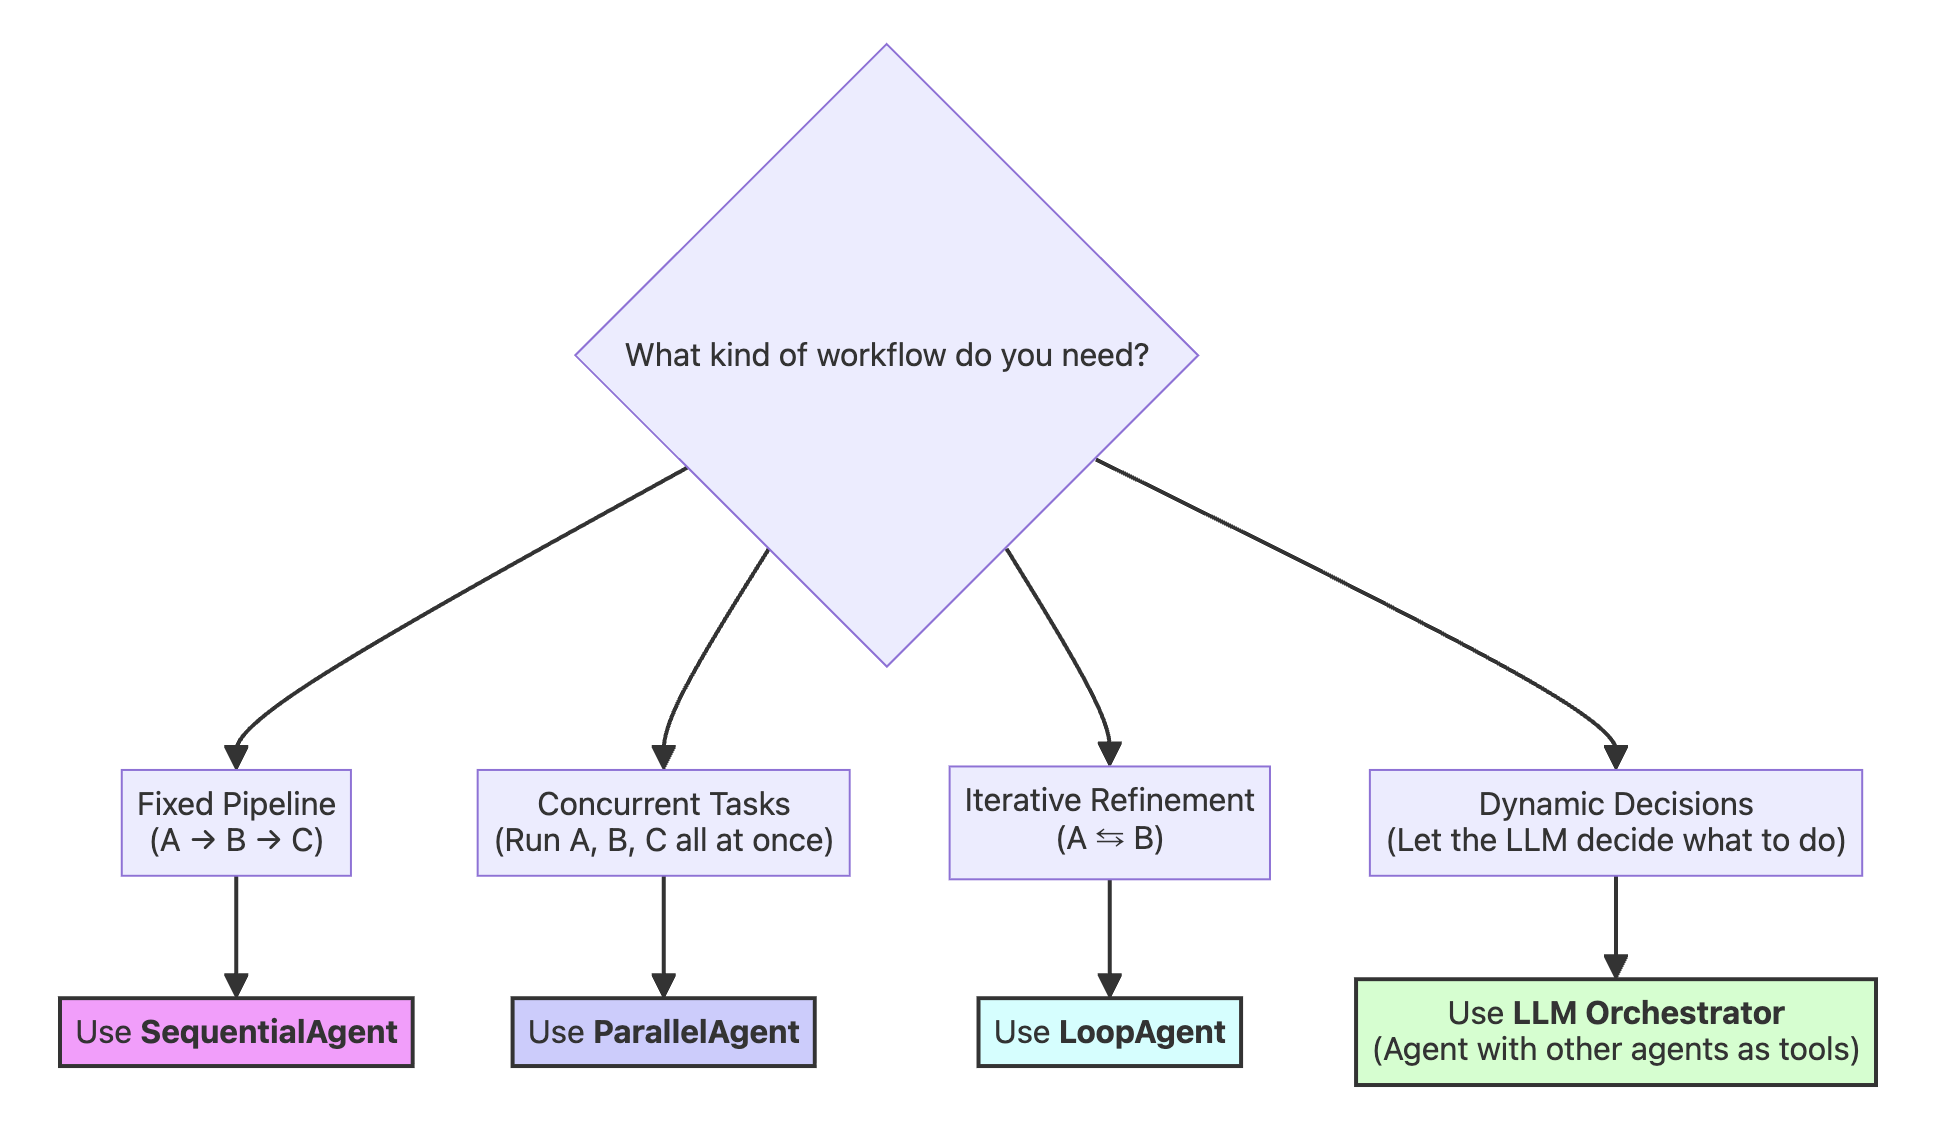

Quick Reference Table
Pattern	When to Use	Example	Key Feature
LLM-based (sub_agents)	Dynamic orchestration needed	Research + Summarize	LLM decides what to call
Sequential	Order matters, linear pipeline	Outline → Write → Edit	Deterministic order
Parallel	Independent tasks, speed matters	Multi-topic research	Concurrent execution
Loop	Iterative improvement needed	Writer + Critic refinement	Repeated cycles
